In [1]:
%matplotlib inline
# %config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt

# import tensorflow as tf
# from tensorflow.keras.layers import (Dense, 
#                                      BatchNormalization, 
#                                      LeakyReLU, 
#                                      Reshape, 
#                                      Conv2DTranspose,
#                                      Conv2D,
#                                      Dropout,
#                                      Flatten)

import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models
from torch.utils.data import Dataset, DataLoader

import mlfuncs
import numpy as np
import pandas as pd
import os
import time
from IPython import display
import PIL

from cnn2d import CNN2D

music_data_folder = 'Data/genres_original/'
image_data_folder = 'Data/images_original/'
features_30_seconds = "Data/features_30_secs.csv"
features_3_seconds = "Data/features_3_secs.csv"

In [2]:
!nvidia-smi

Mon Dec  6 22:01:38 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.82.00    Driver Version: 470.82.00    CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  Off  | 00000000:03:00.0 Off |                  N/A |
| 33%   64C    P8    15W / 250W |     15MiB / 12212MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
from PIL import Image

def create_dataset_PIL(img_folder):
    
    img_data_array=[]
    class_name=[]
    for dir1 in os.listdir(img_folder):
        for file in os.listdir(os.path.join(img_folder, dir1)):
       
            image_path= os.path.join(img_folder, dir1,  file)
            image = Image.open(image_path)
            image = image.resize((224,224),Image.ANTIALIAS)
            image= np.array(image)
#             image= np.resize(image,(288,img_width,3))
            image = image.astype('float32')
            image = image[:, :, :3]
            image = image / 256
            im_mean = [0.485, 0.456, 0.406]
            im_std = [0.229, 0.224, 0.225]
            
            image = (image -im_mean)/im_std
            img_data_array.append(image)
            class_name.append(dir1)
    class_name = np.array(class_name).reshape(-1,1)
    return np.array(img_data_array) , class_name

In [4]:
images, labels=create_dataset_PIL(image_data_folder)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


['rock']


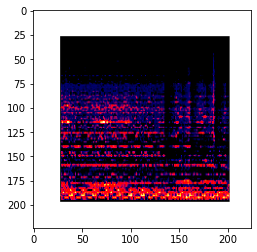

In [5]:
print(labels[100])
plt.imshow(images[100],cmap='cool');

In [6]:
images.shape, labels.shape

((999, 224, 224, 3), (999, 1))

### Utils

This function will generate random n folds of train, val and test sets

In [11]:
# def generate_k_fold_cross_validation_sets(X, T, n_folds, shuffle=True):

#     if shuffle:
#         # Randomly order X and T
#         randorder = np.arange(X.shape[0])
#         np.random.shuffle(randorder)
#         X = X[randorder, :]
#         T = T[randorder, :]

#     # Partition X and T into folds
#     n_samples = X.shape[0]
#     n_per_fold = round(n_samples / n_folds)
#     n_last_fold = n_samples - n_per_fold * (n_folds - 1)

#     folds = []
#     start = 0
#     for foldi in range(n_folds-1):
#         folds.append( (X[start:start + n_per_fold, :], T[start:start + n_per_fold, :]) )
#         start += n_per_fold
#     folds.append( (X[start:, :], T[start:, :]) )

#     # Yield k(k-1) assignments of Xtrain, Train, Xvalidate, Tvalidate, Xtest, Ttest

#     for validation_i in range(n_folds):
#         for test_i in range(n_folds):
#             if test_i == validation_i:
#                 continue

#             train_i = np.setdiff1d(range(n_folds), [validation_i, test_i])

#             Xvalidate, Tvalidate = folds[validation_i]
#             Xtest, Ttest = folds[test_i]
#             if len(train_i) > 1:
#                 Xtrain = np.vstack([folds[i][0] for i in train_i])
#                 Ttrain = np.vstack([folds[i][1] for i in train_i])
#             else:
#                 Xtrain, Ttrain = folds[train_i[0]]

#             yield Xtrain, Ttrain, Xvalidate, Tvalidate, Xtest, Ttest

def percent_correct(Y, T):
    return np.mean(T == Y) * 100            

def confusion_matrix(Y_classes, T):
    class_names = np.unique(T)
    table = []
    for true_class in class_names:
        row = []
        for Y_class in class_names:
            row.append(100 * np.mean(Y_classes[T == true_class] == Y_class))
        table.append(row)
    conf_matrix = pd.DataFrame(table, index=class_names, columns=class_names)
    # cf.style.background_gradient(cmap='Blues').format("{:.1f} %")
    print('Percent Correct ', percent_correct(Y_classes, T))
    return conf_matrix.style.background_gradient(cmap='Blues').format("{:.1f}")

### Evaluating image dataset


#### Using a simple CNN model.


In [30]:
X = images.reshape(-1, 3, 224, 224)
T = labels

In [10]:
Xtrain, Ttrain, Xvalidate, Tvalidate, Xtest, Ttest = next(generate_k_fold_cross_validation_sets(X, T, 5))

In [29]:
n_hiddens_per_conv_layer = [20, 20, 20]
patch_size_per_conv_layer = [10, 5, 5]
stride_per_conv_layer=[12, 2, 3]
n_hiddens_per_fc_layer = [20, 50, 10]
device = torch.device('cuda:0')

In [ ]:
n_epochs = 1000
batch_size = 100
learning_rate = 0.01

In [31]:
n_epochs = 1000
batch_size = 100
learning_rate = 0.01
n_hiddens_per_conv_layer = [20, 20, 20]
patch_size_per_conv_layer = [10, 5, 5]
stride_per_conv_layer=[12, 2, 3]
n_hiddens_per_fc_layer = [20, 50, 10]
device = torch.device('cuda:0')


cnnet = CNN2D(3, 224 * 224, n_hiddens_per_conv_layer, n_hiddens_per_fc_layer, len(np.unique(Ttrain)), patch_size_per_conv_layer, stride_per_conv_layer, activation_function='tanh', device=device)

cnnet.train(Xtrain, Ttrain, batch_size, n_epochs, learning_rate, method='adam')

adam: Epoch 100 Loss 0.486
adam: Epoch 200 Loss 0.332
adam: Epoch 300 Loss 0.129
adam: Epoch 400 Loss 0.192
adam: Epoch 500 Loss 0.029
adam: Epoch 600 Loss 0.005
adam: Epoch 700 Loss 0.002
adam: Epoch 800 Loss 0.002
adam: Epoch 900 Loss 0.001
adam: Epoch 1000 Loss 0.001


CNN2D(
  (conv_layers): ModuleList(
    (0): Conv2d(3, 20, kernel_size=(10, 10), stride=(12, 12))
    (1): Conv2d(20, 20, kernel_size=(5, 5), stride=(2, 2))
    (2): Conv2d(20, 20, kernel_size=(5, 5), stride=(3, 3))
  )
  (fc_layers): ModuleList(
    (0): Linear(in_features=20, out_features=20, bias=True)
    (1): Linear(in_features=20, out_features=50, bias=True)
    (2): Linear(in_features=50, out_features=10, bias=True)
    (3): Linear(in_features=10, out_features=10, bias=True)
  )
)

In [32]:
results_images.append([learning_rate, batch_size, n_epochs, n_hiddens_per_fc_layer, (n_hiddens_per_conv_layer, patch_size_per_conv_layer, stride_per_conv_layer), percent_correct(cnnet.use(Xtrain)[0], Ttrain), percent_correct(cnnet.use(Xvalidate)[0], Tvalidate), percent_correct(cnnet.use(Xtest)[0], Ttest)])

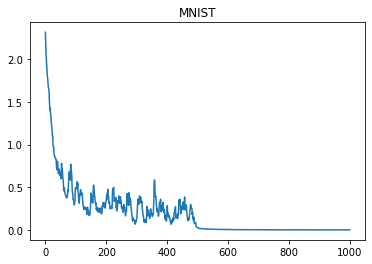

In [33]:
plt.plot(cnnet.error_trace, label='Pytorch')
plt.title('MNIST');

In [34]:
Yval, _ = cnnet.use(Xvalidate)
Ytest, _ = cnnet.use(Xtest)

In [35]:
confusion_matrix(Yval, Tvalidate)

Percent Correct  33.66834170854271


,blues,classical,country,disco,hiphop,jazz,metal,pop,reggae,rock
blues,30.0,0.0,10.0,5.0,10.0,10.0,15.0,0.0,10.0,10.0
classical,15.0,50.0,0.0,0.0,5.0,15.0,0.0,5.0,5.0,5.0
country,20.0,10.0,15.0,5.0,15.0,5.0,10.0,0.0,0.0,20.0
disco,5.0,10.0,20.0,10.0,15.0,0.0,10.0,0.0,10.0,20.0
hiphop,0.0,0.0,0.0,10.0,30.0,0.0,0.0,10.0,50.0,0.0
jazz,15.8,5.3,0.0,0.0,5.3,52.6,0.0,5.3,10.5,5.3
metal,5.0,0.0,5.0,10.0,10.0,0.0,65.0,0.0,0.0,5.0
pop,0.0,5.0,0.0,20.0,20.0,5.0,5.0,40.0,5.0,0.0
reggae,10.0,5.0,0.0,15.0,30.0,5.0,0.0,10.0,25.0,0.0
rock,20.0,10.0,5.0,5.0,5.0,5.0,25.0,5.0,0.0,20.0


In [36]:
confusion_matrix(Ytest, Ttest)

Percent Correct  41.70854271356784


,blues,classical,country,disco,hiphop,jazz,metal,pop,reggae,rock
blues,25.0,10.0,15.0,0.0,15.0,15.0,0.0,10.0,10.0,0.0
classical,15.0,55.0,5.0,0.0,5.0,20.0,0.0,0.0,0.0,0.0
country,25.0,15.0,25.0,0.0,0.0,15.0,5.0,0.0,0.0,15.0
disco,15.0,0.0,0.0,30.0,20.0,0.0,10.0,0.0,5.0,20.0
hiphop,5.0,0.0,10.0,15.0,35.0,0.0,0.0,0.0,30.0,5.0
jazz,5.3,15.8,5.3,5.3,0.0,57.9,0.0,5.3,0.0,5.3
metal,0.0,0.0,5.0,5.0,0.0,0.0,70.0,0.0,0.0,20.0
pop,5.0,5.0,0.0,10.0,5.0,0.0,0.0,65.0,10.0,0.0
reggae,10.0,10.0,0.0,0.0,20.0,10.0,0.0,15.0,25.0,10.0
rock,20.0,0.0,10.0,15.0,10.0,5.0,5.0,5.0,0.0,30.0


In [37]:
n_hiddens_per_conv_layer = [20, 20, 20]
patch_size_per_conv_layer = [10, 5, 5]
stride_per_conv_layer=[12, 2, 3]
n_hiddens_per_fc_layer = []
device = torch.device('cuda:0')

cnnet = CNN2D(3, 224 * 224, n_hiddens_per_conv_layer, n_hiddens_per_fc_layer, len(np.unique(Ttrain)), patch_size_per_conv_layer, stride_per_conv_layer, activation_function='tanh', device=device)

cnnet.train(Xtrain, Ttrain, batch_size, n_epochs, learning_rate, method='adam')

adam: Epoch 100 Loss 0.005
adam: Epoch 200 Loss 0.001
adam: Epoch 300 Loss 0.001
adam: Epoch 400 Loss 0.000
adam: Epoch 500 Loss 0.000
adam: Epoch 600 Loss 0.000
adam: Epoch 700 Loss 0.000
adam: Epoch 800 Loss 0.000
adam: Epoch 900 Loss 0.000
adam: Epoch 1000 Loss 0.000


CNN2D(
  (conv_layers): ModuleList(
    (0): Conv2d(3, 20, kernel_size=(10, 10), stride=(12, 12))
    (1): Conv2d(20, 20, kernel_size=(5, 5), stride=(2, 2))
    (2): Conv2d(20, 20, kernel_size=(5, 5), stride=(3, 3))
  )
  (fc_layers): ModuleList(
    (0): Linear(in_features=20, out_features=10, bias=True)
  )
)

In [38]:
results_images.append([learning_rate, batch_size, n_epochs, n_hiddens_per_fc_layer, (n_hiddens_per_conv_layer, patch_size_per_conv_layer, stride_per_conv_layer), percent_correct(cnnet.use(Xtrain)[0], Ttrain), percent_correct(cnnet.use(Xvalidate)[0], Tvalidate), percent_correct(cnnet.use(Xtest)[0], Ttest)])

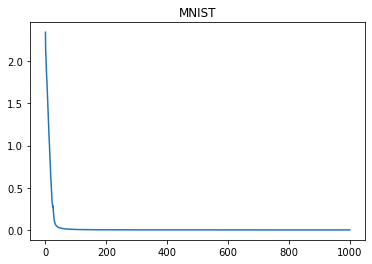

In [39]:
plt.plot(cnnet.error_trace, label='Pytorch')
plt.title('MNIST');

In [40]:
Yval, _ = cnnet.use(Xvalidate)
Ytest, _ = cnnet.use(Xtest)

In [41]:
confusion_matrix(Yval, Tvalidate)

Percent Correct  43.21608040201005


,blues,classical,country,disco,hiphop,jazz,metal,pop,reggae,rock
blues,30.0,5.0,25.0,10.0,0.0,10.0,5.0,5.0,5.0,5.0
classical,5.0,65.0,10.0,0.0,0.0,5.0,0.0,10.0,5.0,0.0
country,5.0,10.0,30.0,10.0,0.0,10.0,0.0,0.0,15.0,20.0
disco,10.0,5.0,10.0,35.0,15.0,5.0,10.0,5.0,0.0,5.0
hiphop,5.0,5.0,0.0,0.0,45.0,0.0,0.0,10.0,30.0,5.0
jazz,10.5,0.0,15.8,0.0,0.0,52.6,0.0,5.3,10.5,5.3
metal,0.0,0.0,0.0,5.0,5.0,0.0,80.0,0.0,5.0,5.0
pop,0.0,5.0,0.0,0.0,15.0,0.0,5.0,60.0,15.0,0.0
reggae,10.0,0.0,10.0,10.0,25.0,5.0,0.0,10.0,25.0,5.0
rock,5.0,5.0,15.0,10.0,15.0,10.0,15.0,15.0,0.0,10.0


In [42]:
confusion_matrix(Ytest, Ttest)

Percent Correct  44.221105527638194


,blues,classical,country,disco,hiphop,jazz,metal,pop,reggae,rock
blues,45.0,10.0,15.0,5.0,0.0,15.0,0.0,0.0,5.0,5.0
classical,10.0,35.0,5.0,10.0,0.0,30.0,0.0,0.0,0.0,10.0
country,20.0,0.0,20.0,0.0,20.0,15.0,0.0,10.0,5.0,10.0
disco,5.0,0.0,5.0,45.0,15.0,0.0,20.0,0.0,5.0,5.0
hiphop,0.0,0.0,0.0,15.0,40.0,5.0,0.0,5.0,35.0,0.0
jazz,15.8,5.3,10.5,0.0,10.5,52.6,0.0,0.0,5.3,0.0
metal,0.0,0.0,0.0,0.0,5.0,0.0,80.0,5.0,0.0,10.0
pop,0.0,5.0,0.0,10.0,5.0,0.0,0.0,80.0,0.0,0.0
reggae,0.0,5.0,0.0,10.0,10.0,15.0,0.0,10.0,30.0,20.0
rock,10.0,5.0,10.0,15.0,5.0,0.0,20.0,10.0,10.0,15.0


#### Finding the best parameters

In [28]:
n_fcs = [[], [100], [128, 512, 1024]]
# ([units],[patches],[strides])
n_convs = [([],[],[]), ([50],[50],[20]), ([50, 50], [40, 10],[20, 5])]
n_epochs = [500]
n_lrs = [0.01]
n_batch_sizes = [100]


In [7]:
X = images.reshape(-1, 3, 224, 224)
T = labels

Xtrain, Ttrain, Xvalidate, Tvalidate, Xtest, Ttest = next(mlfuncs.generate_partitions(X, T, 10, classification=True))

In [15]:
results_images = []

In [31]:
nn_num = 1

for lr in n_lrs:
    for bs in n_batch_sizes:
        for epochs in n_epochs:
            for fc in n_fcs:
                for (c_units, patches, strides) in n_convs:
                    print('Network#{}'.format(nn_num), end=' ')
                    nn_num +=1
                    
                    cnnet = CNN2D(3, 224 * 224, c_units, fc, len(np.unique(Ttrain)), patches, strides, device=device)

                    cnnet.train(Xtrain, Ttrain, bs, epochs, lr, method='adam', verbose=False)
                    tr_ac = percent_correct(cnnet.use(Xtrain)[0], Ttrain)
                    val_ac = percent_correct(cnnet.use(Xvalidate)[0], Tvalidate)
                    te_ac = percent_correct(cnnet.use(Xtest)[0], Ttest)
                    
                    result = [lr, bs, epochs, fc, (c_units, patches, strides), tr_ac, val_ac, te_ac]
                    results_images.append(result)
                    print(result)

Network#1 [0.01, 100, 500, [], ([], [], []), 99.37578027465668, 51.515151515151516, 52.52525252525253]
Network#2 [0.01, 100, 500, [], ([50], [50], [20]), 98.62671660424469, 48.484848484848484, 40.4040404040404]
Network#3 [0.01, 100, 500, [], ([50, 50], [40, 10], [20, 5]), 71.91011235955057, 38.38383838383838, 35.35353535353536]
Network#4 [0.01, 100, 500, [100], ([], [], []), 58.30212234706617, 38.38383838383838, 35.35353535353536]
Network#5 [0.01, 100, 500, [100], ([50], [50], [20]), 73.5330836454432, 40.4040404040404, 36.36363636363637]
Network#6 [0.01, 100, 500, [100], ([50, 50], [40, 10], [20, 5]), 75.03121098626715, 41.41414141414141, 34.34343434343434]
Network#7 [0.01, 100, 500, [128, 512, 1024], ([], [], []), 31.086142322097377, 27.27272727272727, 21.21212121212121]
Network#8 [0.01, 100, 500, [128, 512, 1024], ([50], [50], [20]), 49.43820224719101, 31.313131313131315, 28.28282828282828]
Network#9 [0.01, 100, 500, [128, 512, 1024], ([50, 50], [40, 10], [20, 5]), 43.07116104868914,

In [27]:
n_fcs = [ [256, 64]]
# ([units],[patches],[strides])
n_convs = [([50],[50],[20]), ([50, 50], [40, 10],[10, 5])]
n_epochs = [1000]
n_lrs = [0.01]
n_batch_sizes = [100,200]
device = torch.device('cuda:0')



nn_num = 1

for lr in n_lrs:
    for bs in n_batch_sizes:
        for epochs in n_epochs:
            for fc in n_fcs:
                for (c_units, patches, strides) in n_convs:
                    print('Network#{}'.format(nn_num), end=' ')
                    nn_num +=1
                    
                    cnnet = CNN2D(3, 224 * 224, c_units, fc, len(np.unique(Ttrain)), patches, strides, device=device)

                    cnnet.train(Xtrain, Ttrain, bs, epochs, lr, method='adam', verbose=True)
                    tr_ac = percent_correct(cnnet.use(Xtrain)[0], Ttrain)
                    val_ac = percent_correct(cnnet.use(Xvalidate)[0], Tvalidate)
                    te_ac = percent_correct(cnnet.use(Xtest)[0], Ttest)
                    
                    result = ['{}-5'.format(lr), bs, epochs, fc, (c_units, patches, strides), tr_ac, val_ac, te_ac]
                    results_images.append(result)
                    print(result)

Network#1 adam: Epoch 100 Loss 1.060
adam: Epoch 200 Loss 0.813
adam: Epoch 300 Loss 0.740
adam: Epoch 400 Loss 0.751
adam: Epoch 500 Loss 0.845
adam: Epoch 600 Loss 0.800
adam: Epoch 700 Loss 0.728
adam: Epoch 800 Loss 0.824
adam: Epoch 900 Loss 0.824
adam: Epoch 1000 Loss 0.722
['0.01-5', 100, 1000, [256, 64], ([50], [50], [20]), 76.2063227953411, 32.663316582914575, 33.66834170854271]
Network#2 adam: Epoch 100 Loss 0.895
adam: Epoch 200 Loss 0.429
adam: Epoch 300 Loss 0.512
adam: Epoch 400 Loss 0.359
adam: Epoch 500 Loss 0.340
adam: Epoch 600 Loss 0.482
adam: Epoch 700 Loss 0.446
adam: Epoch 800 Loss 0.425
adam: Epoch 900 Loss 0.198
adam: Epoch 1000 Loss 0.388
['0.01-5', 100, 1000, [256, 64], ([50, 50], [40, 10], [10, 5]), 88.35274542429285, 37.185929648241206, 35.678391959798994]
Network#3 adam: Epoch 100 Loss 0.794
adam: Epoch 200 Loss 0.592
adam: Epoch 300 Loss 0.483
adam: Epoch 400 Loss 0.424
adam: Epoch 500 Loss 0.505
adam: Epoch 600 Loss 0.385
adam: Epoch 700 Loss 0.236
adam: 

In [43]:
results_images_df = pd.DataFrame(results_images, columns=['lr', 'bs', 'epochs', 'fc','convs' , 'train', 'validate', 'test'])

results_images_df

,lr,bs,epochs,fc,convs,train,validate,test
0,0.01,100,1000,"[256, 64]","([50], [50], [20])",78.901373,35.353535,37.373737
1,0.01,100,1000,"[256, 64]","([50, 50], [40, 10], [10, 5])",71.161049,31.313131,24.242424
2,0.01,200,1000,"[256, 64]","([50], [50], [20])",82.521848,43.434343,43.434343
3,0.01,200,1000,"[256, 64]","([50, 50], [40, 10], [10, 5])",91.385768,38.383838,38.383838
4,0.01-5,100,1000,"[256, 64]","([50], [50], [20])",76.206323,32.663317,33.668342
5,0.01-5,100,1000,"[256, 64]","([50, 50], [40, 10], [10, 5])",88.352745,37.185930,35.678392
6,0.01-5,200,1000,"[256, 64]","([50], [50], [20])",74.209651,29.648241,32.160804
7,0.01-5,200,1000,"[256, 64]","([50, 50], [40, 10], [10, 5])",92.845258,33.668342,40.201005
8,0.01,100,1000,"[20, 50, 10]","([20, 20, 20], [10, 5, 5], [12, 2, 3])",99.833611,33.668342,41.708543
9,0.01,100,1000,[],"([20, 20, 20], [10, 5, 5], [12, 2, 3])",100.000000,43.216080,44.221106


In [34]:
# results_images_df.to_csv('results_images.csv', index=False)

In [9]:
results_images_df = pd.read_csv('results_images.csv')

results_images_df

,lr,bs,epochs,fc,convs,train,validate,test
0,0.010,100,500,[],"([], [], [])",99.375780,51.515152,52.525253
1,0.010,100,500,[],"([50], [50], [20])",98.626717,48.484848,40.404040
2,0.010,100,500,[],"([50, 50], [40, 10], [20, 5])",71.910112,38.383838,35.353535
3,0.010,100,500,[100],"([], [], [])",58.302122,38.383838,35.353535
4,0.010,100,500,[100],"([50], [50], [20])",73.533084,40.404040,36.363636
5,0.010,100,500,[100],"([50, 50], [40, 10], [20, 5])",75.031211,41.414141,34.343434
6,0.010,100,500,"[128, 512, 1024]","([], [], [])",31.086142,27.272727,21.212121
7,0.010,100,500,"[128, 512, 1024]","([50], [50], [20])",49.438202,31.313131,28.282828
8,0.010,100,500,"[128, 512, 1024]","([50, 50], [40, 10], [20, 5])",43.071161,26.262626,27.272727
9,0.005,128,700,[],"([], [], [])",97.128589,55.555556,46.464646


In [11]:
results_images_df.sort_values(['validate', 'test', 'train'])

,lr,bs,epochs,fc,convs,train,validate,test
8,0.010,100,500,"[128, 512, 1024]","([50, 50], [40, 10], [20, 5])",43.071161,26.262626,27.272727
6,0.010,100,500,"[128, 512, 1024]","([], [], [])",31.086142,27.272727,21.212121
15,0.005,128,700,"[224, 50]","([], [], [])",63.670412,29.292929,30.303030
7,0.010,100,500,"[128, 512, 1024]","([50], [50], [20])",49.438202,31.313131,28.282828
13,0.005,128,700,[224],"([50], [20], [5])",65.543071,34.343434,40.404040
12,0.005,128,700,[224],"([], [], [])",72.034956,37.373737,27.272727
3,0.010,100,500,[100],"([], [], [])",58.302122,38.383838,35.353535
2,0.010,100,500,[],"([50, 50], [40, 10], [20, 5])",71.910112,38.383838,35.353535
4,0.010,100,500,[100],"([50], [50], [20])",73.533084,40.404040,36.363636
5,0.010,100,500,[100],"([50, 50], [40, 10], [20, 5])",75.031211,41.414141,34.343434


In [44]:
results_images_df.sort_values(['validate', 'test', 'train'])

,lr,bs,epochs,fc,convs,train,validate,test
6,0.01-5,200,1000,"[256, 64]","([50], [50], [20])",74.209651,29.648241,32.160804
1,0.01,100,1000,"[256, 64]","([50, 50], [40, 10], [10, 5])",71.161049,31.313131,24.242424
4,0.01-5,100,1000,"[256, 64]","([50], [50], [20])",76.206323,32.663317,33.668342
7,0.01-5,200,1000,"[256, 64]","([50, 50], [40, 10], [10, 5])",92.845258,33.668342,40.201005
8,0.01,100,1000,"[20, 50, 10]","([20, 20, 20], [10, 5, 5], [12, 2, 3])",99.833611,33.668342,41.708543
0,0.01,100,1000,"[256, 64]","([50], [50], [20])",78.901373,35.353535,37.373737
5,0.01-5,100,1000,"[256, 64]","([50, 50], [40, 10], [10, 5])",88.352745,37.185930,35.678392
3,0.01,200,1000,"[256, 64]","([50, 50], [40, 10], [10, 5])",91.385768,38.383838,38.383838
9,0.01,100,1000,[],"([20, 20, 20], [10, 5, 5], [12, 2, 3])",100.000000,43.216080,44.221106
2,0.01,200,1000,"[256, 64]","([50], [50], [20])",82.521848,43.434343,43.434343


In [8]:

final_results = []



In [9]:
# 0.01	200	1000	[256, 64]	([50], [50], [20])	82.521848	43.434343	43.434343

n_epochs = 2500
batch_size = 200
learning_rate = 0.01
n_hiddens_per_conv_layer = [50]
patch_size_per_conv_layer = [50]
stride_per_conv_layer=[20]
n_hiddens_per_fc_layer = [256, 64]
device = torch.device('cuda:0')


cnnet = CNN2D(3, 224 * 224, n_hiddens_per_conv_layer, n_hiddens_per_fc_layer, len(np.unique(Ttrain)), patch_size_per_conv_layer, stride_per_conv_layer, activation_function='tanh', device=device)

cnnet.train(Xtrain, Ttrain, batch_size, n_epochs, learning_rate, method='adam')

adam: Epoch 250 Loss 0.822
adam: Epoch 500 Loss 0.638
adam: Epoch 750 Loss 0.504
adam: Epoch 1000 Loss 0.441
adam: Epoch 1250 Loss 0.473
adam: Epoch 1500 Loss 0.491
adam: Epoch 1750 Loss 0.739
adam: Epoch 2000 Loss 0.522
adam: Epoch 2250 Loss 0.616
adam: Epoch 2500 Loss 0.574


CNN2D(
  (conv_layers): ModuleList(
    (0): Conv2d(3, 50, kernel_size=(50, 50), stride=(20, 20))
  )
  (fc_layers): ModuleList(
    (0): Linear(in_features=4050, out_features=256, bias=True)
    (1): Linear(in_features=256, out_features=64, bias=True)
    (2): Linear(in_features=64, out_features=10, bias=True)
  )
)

In [12]:
final_results.append([learning_rate, batch_size, n_epochs, n_hiddens_per_fc_layer, (n_hiddens_per_conv_layer, patch_size_per_conv_layer, stride_per_conv_layer), percent_correct(cnnet.use(Xtrain)[0], Ttrain), percent_correct(cnnet.use(Xvalidate)[0], Tvalidate), percent_correct(cnnet.use(Xtest)[0], Ttest)])

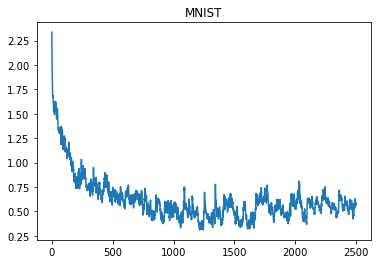

In [13]:
plt.plot(cnnet.error_trace, label='Pytorch')
plt.title('MNIST');

In [14]:
Yval, _ = cnnet.use(Xvalidate)
Ytest, _ = cnnet.use(Xtest)

In [15]:
confusion_matrix(Yval, Tvalidate)

Percent Correct  38.38383838383838


,blues,classical,country,disco,hiphop,jazz,metal,pop,reggae,rock
blues,50.0,0.0,10.0,0.0,0.0,10.0,0.0,0.0,10.0,20.0
classical,10.0,60.0,0.0,0.0,0.0,30.0,0.0,0.0,0.0,0.0
country,20.0,0.0,30.0,20.0,10.0,20.0,0.0,0.0,0.0,0.0
disco,10.0,0.0,20.0,10.0,0.0,0.0,30.0,10.0,10.0,10.0
hiphop,20.0,0.0,0.0,0.0,40.0,10.0,10.0,10.0,0.0,10.0
jazz,33.3,0.0,0.0,0.0,11.1,44.4,0.0,0.0,0.0,11.1
metal,10.0,0.0,0.0,0.0,0.0,0.0,80.0,10.0,0.0,0.0
pop,20.0,0.0,10.0,20.0,10.0,10.0,0.0,30.0,0.0,0.0
reggae,30.0,0.0,0.0,10.0,10.0,0.0,0.0,10.0,30.0,10.0
rock,10.0,0.0,10.0,50.0,0.0,0.0,10.0,10.0,0.0,10.0


In [16]:
confusion_matrix(Ytest, Ttest)

Percent Correct  36.36363636363637


,blues,classical,country,disco,hiphop,jazz,metal,pop,reggae,rock
blues,40.0,10.0,0.0,10.0,10.0,0.0,10.0,0.0,0.0,20.0
classical,0.0,90.0,10.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
country,10.0,10.0,40.0,0.0,10.0,10.0,0.0,0.0,10.0,10.0
disco,0.0,10.0,20.0,30.0,0.0,0.0,0.0,20.0,0.0,20.0
hiphop,30.0,0.0,0.0,10.0,20.0,0.0,10.0,20.0,10.0,0.0
jazz,55.6,11.1,11.1,0.0,0.0,0.0,0.0,0.0,22.2,0.0
metal,10.0,0.0,10.0,0.0,0.0,0.0,60.0,10.0,10.0,0.0
pop,20.0,10.0,10.0,10.0,10.0,10.0,0.0,20.0,0.0,10.0
reggae,0.0,0.0,0.0,10.0,20.0,10.0,10.0,10.0,40.0,0.0
rock,20.0,0.0,30.0,0.0,20.0,0.0,0.0,10.0,0.0,20.0


In [17]:
# 0.005	128	700	[]	([], [], [])	97.128589	55.555556	46.464646


n_epochs = 5000
batch_size = 128
learning_rate = 0.005
n_hiddens_per_conv_layer = []
patch_size_per_conv_layer = []
stride_per_conv_layer=[]
n_hiddens_per_fc_layer = []
device = torch.device('cuda:0')


cnnet = CNN2D(3, 224 * 224, n_hiddens_per_conv_layer, n_hiddens_per_fc_layer, len(np.unique(Ttrain)), patch_size_per_conv_layer, stride_per_conv_layer, activation_function='tanh', device=device)

cnnet.train(Xtrain, Ttrain, batch_size, n_epochs, learning_rate, method='adam')

adam: Epoch 500 Loss 0.485
adam: Epoch 1000 Loss 0.552
adam: Epoch 1500 Loss 0.556
adam: Epoch 2000 Loss 0.556
adam: Epoch 2500 Loss 0.557
adam: Epoch 3000 Loss 0.557
adam: Epoch 3500 Loss 0.557
adam: Epoch 4000 Loss 0.557
adam: Epoch 4500 Loss 0.557
adam: Epoch 5000 Loss 0.557


CNN2D(
  (conv_layers): ModuleList()
  (fc_layers): ModuleList(
    (0): Linear(in_features=150528, out_features=10, bias=True)
  )
)

In [18]:
final_results.append([learning_rate, batch_size, n_epochs, n_hiddens_per_fc_layer, (n_hiddens_per_conv_layer, patch_size_per_conv_layer, stride_per_conv_layer), percent_correct(cnnet.use(Xtrain)[0], Ttrain), percent_correct(cnnet.use(Xvalidate)[0], Tvalidate), percent_correct(cnnet.use(Xtest)[0], Ttest)])

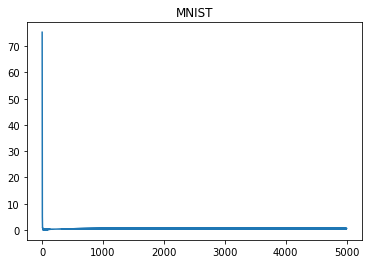

In [19]:
plt.plot(cnnet.error_trace, label='Pytorch')
plt.title('MNIST');

In [20]:
Yval, _ = cnnet.use(Xvalidate)
Ytest, _ = cnnet.use(Xtest)

In [21]:
confusion_matrix(Yval, Tvalidate)

Percent Correct  48.484848484848484


,blues,classical,country,disco,hiphop,jazz,metal,pop,reggae,rock
blues,50.0,10.0,0.0,0.0,0.0,0.0,10.0,0.0,10.0,20.0
classical,0.0,100.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
country,20.0,0.0,40.0,10.0,0.0,10.0,10.0,0.0,10.0,0.0
disco,10.0,0.0,0.0,0.0,10.0,0.0,70.0,0.0,0.0,10.0
hiphop,10.0,0.0,10.0,10.0,40.0,0.0,10.0,10.0,10.0,0.0
jazz,11.1,11.1,11.1,0.0,0.0,66.7,0.0,0.0,0.0,0.0
metal,0.0,0.0,0.0,0.0,0.0,0.0,100.0,0.0,0.0,0.0
pop,0.0,10.0,0.0,10.0,0.0,0.0,0.0,60.0,10.0,10.0
reggae,20.0,0.0,0.0,0.0,30.0,0.0,10.0,30.0,10.0,0.0
rock,0.0,0.0,0.0,10.0,0.0,0.0,60.0,10.0,0.0,20.0


In [22]:
confusion_matrix(Ytest, Ttest)

Percent Correct  54.54545454545454


,blues,classical,country,disco,hiphop,jazz,metal,pop,reggae,rock
blues,70.0,0.0,10.0,10.0,0.0,0.0,0.0,0.0,0.0,10.0
classical,10.0,60.0,10.0,0.0,0.0,20.0,0.0,0.0,0.0,0.0
country,0.0,10.0,50.0,10.0,10.0,10.0,0.0,0.0,0.0,10.0
disco,0.0,10.0,10.0,40.0,0.0,0.0,0.0,20.0,10.0,10.0
hiphop,0.0,10.0,0.0,0.0,60.0,0.0,10.0,10.0,10.0,0.0
jazz,11.1,33.3,11.1,0.0,0.0,44.4,0.0,0.0,0.0,0.0
metal,0.0,0.0,0.0,0.0,10.0,0.0,80.0,10.0,0.0,0.0
pop,10.0,10.0,0.0,0.0,0.0,10.0,0.0,50.0,10.0,10.0
reggae,10.0,10.0,0.0,0.0,0.0,0.0,10.0,20.0,50.0,0.0
rock,0.0,10.0,10.0,10.0,0.0,0.0,20.0,10.0,0.0,40.0


In [23]:
# 0.005	128	700	[]	([50, 50], [40, 10], [10, 5])	98.127341	50.505051	45.454545



n_epochs = 5000
batch_size = 128
learning_rate = 0.005
n_hiddens_per_conv_layer = [50, 50]
patch_size_per_conv_layer = [40, 10]
stride_per_conv_layer=[10, 5]
n_hiddens_per_fc_layer = []
device = torch.device('cuda:0')


cnnet = CNN2D(3, 224 * 224, n_hiddens_per_conv_layer, n_hiddens_per_fc_layer, len(np.unique(Ttrain)), patch_size_per_conv_layer, stride_per_conv_layer, activation_function='tanh', device=device)

cnnet.train(Xtrain, Ttrain, batch_size, n_epochs, learning_rate, method='adam')

adam: Epoch 500 Loss 0.002
adam: Epoch 1000 Loss 0.002
adam: Epoch 1500 Loss 0.002
adam: Epoch 2000 Loss 0.002
adam: Epoch 2500 Loss 0.002
adam: Epoch 3000 Loss 0.002
adam: Epoch 3500 Loss 0.278
adam: Epoch 4000 Loss 0.010
adam: Epoch 4500 Loss 0.004
adam: Epoch 5000 Loss 0.003


CNN2D(
  (conv_layers): ModuleList(
    (0): Conv2d(3, 50, kernel_size=(40, 40), stride=(10, 10))
    (1): Conv2d(50, 50, kernel_size=(10, 10), stride=(5, 5))
  )
  (fc_layers): ModuleList(
    (0): Linear(in_features=200, out_features=10, bias=True)
  )
)

In [24]:
final_results.append([learning_rate, batch_size, n_epochs, n_hiddens_per_fc_layer, (n_hiddens_per_conv_layer, patch_size_per_conv_layer, stride_per_conv_layer), percent_correct(cnnet.use(Xtrain)[0], Ttrain), percent_correct(cnnet.use(Xvalidate)[0], Tvalidate), percent_correct(cnnet.use(Xtest)[0], Ttest)])

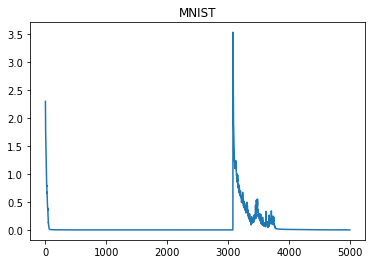

In [25]:
plt.plot(cnnet.error_trace, label='Pytorch')
plt.title('MNIST');

In [26]:
Yval, _ = cnnet.use(Xvalidate)
Ytest, _ = cnnet.use(Xtest)

In [27]:
confusion_matrix(Yval, Tvalidate)

Percent Correct  43.43434343434344


,blues,classical,country,disco,hiphop,jazz,metal,pop,reggae,rock
blues,40.0,10.0,0.0,0.0,10.0,10.0,0.0,0.0,10.0,20.0
classical,20.0,70.0,0.0,0.0,0.0,0.0,0.0,10.0,0.0,0.0
country,0.0,0.0,20.0,30.0,10.0,20.0,10.0,0.0,10.0,0.0
disco,10.0,0.0,0.0,30.0,20.0,0.0,10.0,10.0,10.0,10.0
hiphop,0.0,20.0,0.0,0.0,40.0,10.0,10.0,0.0,20.0,0.0
jazz,0.0,0.0,22.2,0.0,0.0,66.7,0.0,0.0,0.0,11.1
metal,0.0,0.0,20.0,0.0,0.0,0.0,80.0,0.0,0.0,0.0
pop,0.0,10.0,10.0,0.0,10.0,0.0,0.0,60.0,0.0,10.0
reggae,0.0,10.0,0.0,0.0,20.0,10.0,10.0,30.0,20.0,0.0
rock,10.0,10.0,10.0,20.0,0.0,10.0,30.0,0.0,0.0,10.0


In [28]:
confusion_matrix(Ytest, Ttest)

Percent Correct  31.313131313131315


,blues,classical,country,disco,hiphop,jazz,metal,pop,reggae,rock
blues,10.0,0.0,20.0,30.0,10.0,0.0,0.0,0.0,30.0,0.0
classical,10.0,70.0,10.0,0.0,0.0,0.0,0.0,0.0,0.0,10.0
country,30.0,10.0,30.0,0.0,0.0,0.0,0.0,0.0,20.0,10.0
disco,0.0,10.0,10.0,20.0,0.0,10.0,0.0,40.0,0.0,10.0
hiphop,30.0,0.0,0.0,0.0,0.0,10.0,0.0,10.0,40.0,10.0
jazz,11.1,11.1,0.0,0.0,0.0,44.4,0.0,0.0,33.3,0.0
metal,0.0,0.0,0.0,0.0,30.0,0.0,60.0,0.0,10.0,0.0
pop,0.0,30.0,20.0,10.0,0.0,0.0,0.0,30.0,0.0,10.0
reggae,0.0,0.0,0.0,10.0,20.0,10.0,0.0,20.0,40.0,0.0
rock,20.0,10.0,0.0,30.0,0.0,0.0,10.0,10.0,10.0,10.0


In [29]:
final_df = pd.DataFrame(final_results, columns = ['lr', 'bs', 'epochs', 'fc','convs' , 'train', 'validate', 'test'])

final_df

,lr,bs,epochs,fc,convs,train,validate,test
0,0.010,200,2500,"[256, 64]","([50], [50], [20])",80.898876,38.383838,36.363636
1,0.005,128,5000,[],"([], [], [])",97.253433,48.484848,54.545455
2,0.005,128,5000,[],"([50, 50], [40, 10], [10, 5])",96.878901,43.434343,31.313131


In [30]:
final_df.sort_values(['validate', 'test'])

,lr,bs,epochs,fc,convs,train,validate,test
0,0.010,200,2500,"[256, 64]","([50], [50], [20])",80.898876,38.383838,36.363636
2,0.005,128,5000,[],"([50, 50], [40, 10], [10, 5])",96.878901,43.434343,31.313131
1,0.005,128,5000,[],"([], [], [])",97.253433,48.484848,54.545455
